In [1]:
import pandas as pd
import numpy as np
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from ipywidgets import interact

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, Product, WhiteKernel, Sum

# get a list of all the colour strings in matplotlib so we can iterate through them
from matplotlib import colors as mcolors
colours = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
colour_list.extend(list(colours.keys()))
# 9 base colours ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua'...

# Behind The Scenes Code

Read in Iteration Data (Training and NNet). Does all of the ugly calculations. Note, when the actions are changed, only self.action_space needs to be changed.

In [2]:
class IterationData:
    """
    A class to load in the data from each iteration to an object in a readable form for later visualisation
    Note:
        GOOD get_state_2d(episode, step)
        BAD state_2ds[\'arr_x\']
    """

    def __init__(self, folder_path, iteration):

        self.training_path = folder_path + 'TrainingExamples' + str(iteration)
        self.nnet_loss_path = folder_path + 'NNetLosses' + str(iteration)

        # data formatting
        self.decimal_places = 3
        self.csv_rows = 6
        self.action_space = [-1, 1]

        # data manipulation
        self.x_threshold = 2.4
        self.theta_threshold_radians = 0.21

        # define a useful class for training examples, so we can access dict memebers as .'key' rather than ['key']
        class ReturnClass(dict):
            def __getattr__(self, name):
                return self[name]

        # just get the number of episodes (need to do this before adding episodes to the dict annoyingly)
        with open(self.training_path + '.csv', 'r', newline='') as f:
            row_count = sum([1 for row in f])
        self.episodes = int(row_count / self.csv_rows)

        # read in training examples data and nnet loss data
        # dict of {ep1: dataframe[2Dstate, TrueValue, PolicyValue, MCTSAction, PolicyAction, Observation], ep2: ...}
        self.episode_data = ReturnClass()
        self.all_data = pd.DataFrame(
            columns=['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Player', 'Observation',
                     'State2D'])
        self.state_2ds = np.load(self.training_path + '.npz')
        self.read_examples()
        self.nnet_losses = self.read_nnet_losses()

    def read_examples(self):
        step_counter = 0
        for episode in range(self.episodes):
            rows = [self.csv_rows * episode + x for x in range(self.csv_rows)]

            # only pick out relevent rows (because others are different lengths -> can't be read)
            episode_data = pd.read_csv(self.training_path + '.csv', header=None,
                                       skiprows=lambda x: x not in rows).transpose()
            episode_data.columns = ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Player',
                                    'Observation']
            episode_data.TrueValue = episode_data.TrueValue.astype(float).round(self.decimal_places)
            episode_data.PolicyValue = episode_data.PolicyValue.astype(float).round(self.decimal_places)
            episode_data.Player = episode_data.Player.astype(int)

            # Split arrays and convert to floats
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.MCTSAction = episode_data.MCTSAction.apply(
                lambda x: [round(float(elm), self.decimal_places) for elm in x])

            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.PolicyAction = episode_data.PolicyAction.apply(
                lambda x: [round(float(elm), self.decimal_places) for elm in x])

            episode_data.Observation = episode_data.Observation.apply(lambda x: x[1:-1].split())
            episode_data.Observation = episode_data.Observation.apply(
                lambda x: [round(float(elm), self.decimal_places) for elm in x])

            # add a reference to the stated2D for each step
            episode_states = list(self.state_2ds)[step_counter:step_counter + episode_data.index[-1] + 1]
            step_counter += episode_data.index[-1] + 1
            episode_data['State2D'] = episode_states

            # and then add the whole dataframe to the dict
            self.episode_data['Episode' + str(episode)] = episode_data
            self.all_data = pd.concat([self.all_data, episode_data], ignore_index=True)

    def read_nnet_losses(self):
        losses = pd.read_csv(self.nnet_loss_path + '.csv', header=None).transpose()
        losses.columns = ['PlayerAction', 'PlayerValue', 'AdversaryAction', 'AdversaryValue']
        return losses

    def get_state_2d(self, episode, step):
        episode = 'Episode' + str(episode)
        return self.state_2ds[self.episode_data[episode].State2D.values[step]]

    def get_episode_length(self, episode):
        episode = 'Episode' + str(episode)
        return self.episode_data[episode].index[-1]

    def get_max_episode(self):
        max_ep_len, max_ep = 0, 0
        for ep in range(self.episodes):
            ep_len = self.get_episode_length(ep)
            if ep_len > max_ep_len:
                max_ep_len = ep_len
                max_ep = ep
        return max_ep

folder = os.path.join('..\Cartpole','Data', 'TrainingData1\\')
# folder = os.path.join('ArchivedData', '0AdversaryXE\\')
iter_data = IterationData(folder, iteration=0)
iter_data.episode_data['Episode0'].tail()
iter_data.all_data.tail()

,TrueValue,PolicyValue,MCTSAction,PolicyAction,Player,Observation,State2D
7262,-0.707,-0.385,"[0.0, 1.0]","[0.443, 0.557]",0,"[2.292, 2.232, 0.181, 0.341]",arr_7262
7263,-0.768,-0.508,"[0.0, 1.0]","[0.434, 0.566]",1,"[2.314, 2.131, 0.184, 0.576]",arr_7263
7264,-0.837,-0.383,"[0.0, 1.0]","[0.449, 0.551]",0,"[2.335, 2.129, 0.19, 0.615]",arr_7264
7265,-0.909,-0.505,"[0.0, 1.0]","[0.432, 0.568]",1,"[2.357, 2.027, 0.196, 0.851]",arr_7265
7266,-0.990,-0.381,"[0.0, 1.0]","[0.455, 0.545]",0,"[2.377, 2.026, 0.205, 0.893]",arr_7266


Class To Visualise a Single Iteration. Generally these don't go quite as far as plotting, they create and return an axes object, which can then be plotted, or used in the Visualise class, which compares iterations

In [8]:
class VisualiseIteration:
    """
    Uses objects of IterationData, which contains methods to easily access data, summarised below:

    Attributes:
        self.episodes = number of episodes in an iteration
        self.nnet_losses = Dataframe with ['PlayerAction', 'AdversaryAction', 'Value', 'Total'] as the column headders
        self.episode_data = A Dictionary of episodes with keys ['EpisodeN'] where N is an int.
                Each episode's value is a pandas dataframe with columns:

    ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Player',  'Observation',      'State2D']
      [ float,      float,         [f, f],        [f, f],       int, [x, xdot, theta, thetadot], 'arr_n']

        self.all_data = all of the episode data joined in columns as above

    Methods:
        get_state_2d(self, episode, step)
        get_episode_length(self, episode)
        get_max_episode(self)
    """

    def __init__(self, folder_path, iteration):

        self.iter = iteration
        self.action_space = [-1, 1]  # [left, right]
        self.action_names = {0: 'Left', 1: 'Right'}
        self.default_action = 0  # left is default action to show (no need to show left and right)
        self.iter_data = IterationData(folder_path, iteration)

        self.x_threshold = self.iter_data.x_threshold
        self.theta_threshold_radians = self.iter_data.theta_threshold_radians

    def add_axis_valuevsstep(self, episode=None, colour='blue', axes=None):
        # extract data for values and actions
        if episode is None:
            episode = self.iter_data.get_max_episode()
        ep_length = self.iter_data.get_episode_length(episode)
        
        # extract player & adv values
        ep = self.iter_data.episode_data['Episode' + str(episode)]
        is_player_0 = ep['Player'] == 0
        player_policy_values = ep.PolicyValue[is_player_0].values
        adv_policy_values = ep.PolicyValue[is_player_0==False].values
        true_values = ep.TrueValue.values
        
        # generate x values for player and adv's
        player_turns = sum(is_player_0)
        adv_turns = ep_length - player_turns
        evens_fix = 0 if ep_length%2 == 0 else 1
        player_xs = np.linspace(0, ep_length - evens_fix, player_turns)  # 100 evenly spaced numbers, [0, 2, ..., 198]
        adv_xs = np.linspace(1, ep_length- 1 + evens_fix, adv_turns+1)

        # check if subplots already exist
        if axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))

        # Value Subplot
        axes.plot(player_xs, player_policy_values, color=colour, linestyle=':', marker='+',
                  label='Player Policy Values, Iter:' + str(self.iter) + ' Ep:' + str(episode))
        axes.plot(adv_xs, adv_policy_values, color=colour, linestyle=':', marker='x',
                  label='Adversary Policy Values, Iter:' + str(self.iter) + ' Ep:' + str(episode))
        axes.plot(true_values, color=colour, linestyle='-',
                  label='True Values, Iter:' + str(self.iter) + ' Ep:' + str(episode))
        axes.legend()
        axes.set_ylabel('State Value')
        axes.set_xlabel('Steps')
        axes.set_ylim(-1, 0)

        return axes

    def add_axis_actionvsstep(self, episode=None, colour='blue', axes=None):

        if episode is None:
            episode = self.iter_data.get_max_episode()
        ep_length = self.iter_data.get_episode_length(episode)
        # check if subplots already exist
        if axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(17, 2 * 7))
        assert isinstance(axes, np.ndarray) and len(axes) == 2, " Not enough Axes"

        # ----- Extract Data -----
        ep = self.iter_data.episode_data['Episode' + str(episode)]
        is_player_0 = ep['Player'] == 0
        policy_player = ep.PolicyAction[is_player_0].values
        mcts_player = ep.MCTSAction[is_player_0].values
        policy_adversary = ep.PolicyAction[is_player_0 == False].values
        mcts_adversary = ep.MCTSAction[is_player_0 == False].values
        
        # generate x values for player and adv's
        player_turns = sum(is_player_0)
        adv_turns = ep_length - player_turns
        evens_fix = 0 if ep_length%2 == 0 else 1
        agent_xs = [np.linspace(0, ep_length - evens_fix, player_turns), np.linspace(1, ep_length- 1 + evens_fix, adv_turns+1)]

        policy_actions = [list(zip(*policy_player))[self.default_action],
                          list(zip(*policy_adversary))[self.default_action]]
        mcts_actions = [list(zip(*mcts_player))[self.default_action], list(zip(*mcts_adversary))[self.default_action]]
        agent = ['Player', 'Adversary']

        # ----- And Plot on Axes -----
        for axis in range(len(axes)):
            axes[axis].plot(agent_xs[axis], policy_actions[axis], color=colour, linestyle='--',
                            label='{:s}\'s Policy Actions, Iter: {} Ep: {}'.format(agent[axis], self.iter, episode))
            axes[axis].plot(agent_xs[axis], mcts_actions[axis], color=colour, linestyle='-',
                            label='{:s}\'s MCTS Actions, Iter: {} Ep: {}'.format(agent[axis], self.iter, episode))
            axes[axis].legend()
            axes[axis].set_ylabel(
                'Probability of {} Pushing {}'.format(agent[axis], self.action_names[self.default_action]))
            axes[axis].set_xlabel('Steps')
            axes[axis].set_ylim(-0.01, 1.01)

        return axes

    def get_episode_value_stats(self):
        averages = -1 * np.ones((200 + 1,))
        deviations = np.zeros((200 + 1,))
        all_episodes = []
        # print(averages.head())
        for ep in range(self.iter_data.episodes):
            true_values = self.iter_data.episode_data['Episode' + str(ep)].TrueValue.values  # TrueValue or PolicyValue
            all_episodes.append(true_values)
            x = self.iter_data.get_episode_length(ep) + 1
            averages[0:x] += true_values
            averages[x:] += -1
            deviations[0:x] += true_values ** 2
            deviations[x:] += 1

        averages = averages / self.iter_data.episodes
        deviations = np.sqrt(deviations - averages ** 2) / self.iter_data.episodes  # to get the standard deviation
        return averages, deviations, all_episodes

    def plot_observations_histogram(self, normalised=True):

        all_observations = self.iter_data.all_data['Observation'].values

        # normalise all the observations
        if normalised:
            all_normed_observations = []
            for step in all_observations:
                obs = [step[0] / self.x_threshold,
                       step[1] / self.x_threshold,
                       step[2] / self.theta_threshold_radians,
                       step[3] / self.theta_threshold_radians,
                       ]
                all_normed_observations.append(obs)
            all_observations = all_normed_observations
        # flip the dimensions
        all_observations = list(zip(*all_observations))

        # Plot histograms
        fig, axes = plt.subplots(ncols=len(all_observations), nrows=1, figsize=(len(all_observations) * 5, 5))
        obs_label = ['x', '$\dot{x}$', '$\\theta$', '$\dot{\\theta}$']
        axes[0].set_ylabel('Probability of Observation')
        for dim in range(len(all_observations)):
            axes[dim].hist(all_observations[dim], bins=20, density=True, color=colour_list[dim], alpha=0.9)
            if normalised:
                axes[dim].set_xlabel('Normalised ' + obs_label[dim])
            else:
                axes[dim].set_xlabel(obs_label[dim])

    def get_actionvsstate_probs(self, policy, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.15):

        shape = self.iter_data.get_state_2d(episode=0, step=0).shape
        x_dot_bin_size = bin_proportion  # /self.x_threshold # either side of the value
        theta_dot_bin_size = bin_proportion  # /self.theta_threshold_radians # either side of the value

        # only 2 actions currently
        player_probs = np.zeros(shape, dtype=float)
        player_counter = np.zeros(shape, dtype=float)
        adv_probs = np.zeros(shape, dtype=float)
        adv_counter = np.zeros(shape, dtype=float)

        action = 'PolicyAction' if policy else 'MCTSAction'
        data = self.iter_data.all_data
        is_player_0 = data['Player'] == 0

        player_actions = list(zip(*data[action][is_player_0].values))[self.default_action]
        adv_actions = list(zip(*data[action][is_player_0 == False].values))[self.default_action]

        obs = list(zip(*self.iter_data.all_data['Observation'].values))
        state_2ds = self.iter_data.all_data['State2D'].values
        obs0, obs1, obs2, obs3 = np.array(obs[0]), np.array(obs[1]), np.array(obs[2]), np.array(obs[3])

        is_near_x_dot = (obs1 > x_dot_fixed - x_dot_bin_size) & (obs1 < x_dot_fixed + x_dot_bin_size)
        is_near_theta_dot = (obs3 > theta_dot_fixed - theta_dot_bin_size) & (
                obs3 < theta_dot_fixed + theta_dot_bin_size)
        filtered_player = np.array(player_actions)[is_near_x_dot & is_near_theta_dot]
        filtered_adv = np.array(adv_actions)[is_near_x_dot & is_near_theta_dot]
        filtered_states = np.array(state_2ds)[is_near_x_dot & is_near_theta_dot]

        for idx, arr_num in enumerate(filtered_states):
            state_2d = self.iter_data.state_2ds[arr_num]
            row, column = np.unravel_index(np.argmax(state_2d, axis=None),
                                           shape)  # get the index of the current element

            player_probs[row, column] += filtered_player[idx]
            player_counter[row, column] += 1

            adv_probs[row, column] += filtered_adv[idx]
            adv_counter[row, column] += 1

        player_probs = np.true_divide(player_probs, player_counter)
        adv_probs = np.true_divide(adv_probs, adv_counter)
        return player_probs, adv_probs

    def plot_action_correlations(self):

        # simply chop off all the extra numbers untill they are the same size
        data = self.iter_data.all_data
        is_player_0 = data['Player'] == 0
        player_df = data[is_player_0]
        adversary_df = data[is_player_0 == False]
        cutoff = min(len(player_df), len(adversary_df))
        player_df = player_df.iloc[:cutoff - 1]
        adversary_df = adversary_df.iloc[:cutoff - 1]

        # get data into right format
        player_policy = list(zip(*player_df['PolicyAction']))[self.default_action]
        adv_policy = list(zip(*adversary_df['PolicyAction']))[self.default_action]
        player_mcts = list(zip(*player_df['MCTSAction']))[self.default_action]
        adv_mcts = list(zip(*adversary_df['MCTSAction']))[self.default_action]
        player_policy, adv_policy = np.array(player_policy), np.array(adv_policy)
        player_mcts, adv_mcts = np.array(player_mcts), np.array(adv_mcts)

        # Instantiate a Gaussian Process model, note DotProduct is just <x, y> == Rotation of linear kernel therefore good for this
        # kernel = Sum(DotProduct(sigma_0=0.1), WhiteKernel(noise_level=0.1))
        # kernel = Sum(Product(DotProduct(sigma_0=0.1), RBF(0.1, (1e-2, 1e1))), WhiteKernel(noise_level=0.5))
        # gp_policy = GaussianProcessRegressor(kernel=kernel, alpha=0.25 ** 2, n_restarts_optimizer=1)
        # gp_mcts = GaussianProcessRegressor(kernel=kernel, alpha=0.25 ** 2, n_restarts_optimizer=1)

        # Fit to data using Maximum Likelihood Estimation of the parameters
        #X_policy, X_mcts = np.atleast_2d(adv_policy).T, np.atleast_2d(adv_mcts).T
        #gp_policy.fit(X_policy, player_policy)
        #gp_mcts.fit(X_mcts, player_mcts)
        #x = np.atleast_2d(np.linspace(0, 1, 100)).T
        #y_policy, s_policy = gp_policy.predict(x, return_std=True)
        #y_mcts, s_mcts = gp_mcts.predict(x, return_std=True)

        # CALCULATE CORRELATION
        corr_player = np.corrcoef(player_policy, adv_policy)[0][1]  # take a non-diagonal element
        corr_mcts = np.corrcoef(player_mcts, adv_mcts)[0][1]  # take a non-diagonal element
        correlation = [corr_player, corr_mcts]

        # SCATTER PLOTS AND FITS
        titles = ['Policy Predictions', 'MCTS Predictions']

        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17, 8))
        player_actions, adv_actions = [player_policy, player_mcts], [adv_policy, adv_mcts]
        #y_pred, sigma = [y_policy, y_mcts], [s_policy, s_mcts]
        for axis in range(len(axes)):
            axes[axis].scatter(adv_actions[axis], player_actions[axis], marker='x')
            axes[axis].set_title("{}, Correlation Coef: {}".format(titles[axis], correlation[axis]))

            # Plot the function, the prediction and the 95% confidence interval based on the MSE
            #axes[axis].plot(x, y_pred[axis], 'b-', label='GP Prediction')
            #axes[axis].fill(np.concatenate([x, x[::-1]]),
            #                np.concatenate([y_pred[axis] - 1.9600 * sigma[axis],
            #                                (y_pred[axis] + 1.9600 * sigma[axis])[::-1]]),
            #                alpha=.5, fc='b', ec='None', label='95% confidence interval')
            axes[axis].set_xlabel('p(Adversary Action = Left)')
            axes[axis].set_ylabel('p(Player Action = Left)')
            axes[axis].set_ylim(-0.01, 1.01)
            axes[axis].set_xlim(-0.01, 1.01)
            axes[axis].legend()

    def add_axis_actionprobvsstate(self, prob_array, axes, agent='player', vs=(0.2, 0.8)):

        image = axes.imshow(prob_array, vmin=vs[0], vmax=vs[1],
                            extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                    self.theta_threshold_radians],
                            cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title('Probability of ' + agent + ' Pushing Left vs Position')

    def plot_state_2d(self, episode, step):
        # Plot MCTS action, action policy and values associated?
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])  # add an axis object to the figure
        state_2d = self.iter_data.get_state_2d(episode, step)

        # returns a colourAxisImage, that we need to map the colourbar to the figure
        mapable = axes.imshow(state_2d, extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                                self.theta_threshold_radians], cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title('The 2D State')



No handles with labels found to put in legend.
No handles with labels found to put in legend.


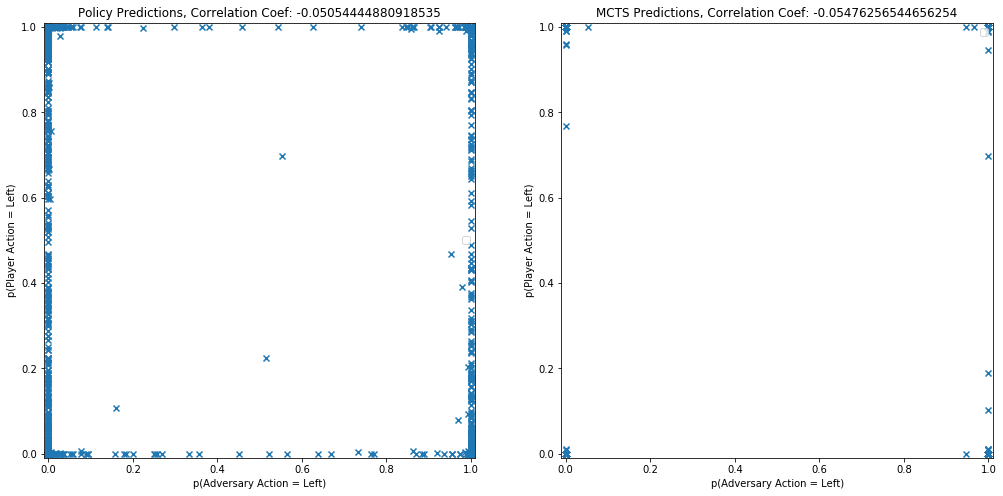

In [9]:
vis = VisualiseIteration(folder, 7)
vis.plot_action_correlations()

In [10]:
class VisualiseIterations:
    """
    VisualiseIterations principally contains a list of VisualiseIteration objects, which in turn contain Iteration data objects
    leading to an objects hirachy of VisualiseIterations <- Iter*VisualiseIteration <- IterationData. The main components of
    the two attribute classes are shown below:

    VisualiseIterations:
    Attributes:
        self.iters_data = [iter_data0, iter_data1, iter_data2, ...]
        self.iterations

    VisualiseIteration:
    Attributes:
        self.iter, self.action_space = [-1, 1], self.action_names ={0: 'Left', 1: 'Right'}
        self.default_action = 0  # left is default action to show (no need to show left and right)
        iter_data = IterationData(folder_path, iteration)
    Methods:
        add_axis_valuevsstep(self, episode=None, colour = 'blue', axes=None)
        add_axis_actionvsstep(self, episode=None, agent='player', colour = 'blue', axes=None)
        get_episode_value_stats(self)
        plot_observations_histogram(self, normalised=True)
        get_actionvsstate_probs(self, policy, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.15)
        add_axis_actionprobvsstate(self, prob_array, axes, agent='player', vs=(0.2, 0.8))
        plot_state_2d(self, episode, step)

    IterationData:
    Attributes:
        self.episodes = number of episodes in an iteration
        self.nnet_losses = Dataframe with ['PlayerAction', 'AdversaryAction', 'Value', 'Total'] as the column headders
        self.episode_data = A Dictionary of episodes with keys ['EpisodeN'] where N is an int.
                Each episode's value is a pandas dataframe with columns:

    ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Player',  'Observation',      'State2D']
      [ float,      float,         [f, f],        [f, f],         int,  [x, xdot, theta, thetadot], 'arr_n']

        self.all_data = all of the episode data joined in columns as above

    Methods:
        get_state_2d(self, episode, step)
        get_episode_length(self, episode)
        get_max_episode(self)
    """

    def __init__(self, data_set_path, iters='all'):
        self.folder_path = data_set_path

        self.iters_data = []
        if iters == 'all':
            self.iterations = 0
            while True:
                try:
                    self.iters_data.append(VisualiseIteration(self.folder_path, self.iterations))
                except:
                    break
                self.iterations += 1
        else:
            assert isinstance(iters, list)
            for itr in iters:
                self.iters_data.append(VisualiseIteration(self.folder_path, itr))
            self.iterations = len(self.iters_data)

        print("There are ", self.iterations, " iterations stored in self.iterations")

    def plot_episode_statsvsstep(self, iters=(0, 1, 2), plot_stds=False, plot_all_eps=False):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"

        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        axes.set_xlabel('Steps')
        axes.set_ylabel('Average Value')
        axes.set_ylim([-1, 0])
        for itr in iters:
            means, std, all_eps = self.iters_data[itr].get_episode_value_stats()

            axes.plot(means, linestyle='-', color=colour_list[itr], label='Itr:' + str(itr) + ' Average Episode Value')
            if plot_stds:
                axes.plot(means + std, linestyle='--', color=colour_list[itr], label=None)
                axes.plot(means - std, linestyle='--', color=colour_list[itr], label=None)
            if plot_all_eps:
                for i in range(self.iters_data[itr].iter_data.episodes):
                    axes.plot(all_eps[i], linestyle=':', label=None)

            axes.legend()

    def plot_nnet_lossesvsbatch(self, iters=(0, 1, 2)):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"

        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])

        axes.set_xlabel('Batches (size 8)')
        axes.set_ylabel('Loss')
        for itr in iters:
            axes.plot(self.iters_data[itr].iter_data.nnet_losses.values)
            axes.legend(['Itr ' + str(itr) + ' Player Action', 'Itr ' + str(itr) + ' Player Value',
                         'Itr ' + str(itr) + ' Adversary Action', 'Itr ' + str(itr) + ' Adversary Value'])

    def plot_observation_histograms(self, iters=(0, 1, 2), normed=True):
        for itr in iters:
            self.iters_data[itr].plot_observations_histogram(normed)

    def plot_valuesvssteps(self, iters=(0, 1, 2), episode='longest'):
        # fig, ax = te0.plot_episode(episode=3, colour='blue')
        max_eps = []
        for itr in iters:
            if episode == 'longest':
                max_eps.append(self.iters_data[itr].iter_data.get_max_episode())
            else:
                max_eps.append(episode)

        # keep plotting iterations on the same axis
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))
        for idx, itr in enumerate(iters):
            ax = self.iters_data[itr].add_axis_valuevsstep(max_eps[idx], colour_list[idx], ax)

    def plot_actionsvssteps(self, iters=(0, 1, 2), episode='longest'):
        max_eps = []
        for itr in iters:
            if episode == 'longest':
                max_eps.append(self.iters_data[itr].iter_data.get_max_episode())
            else:
                max_eps.append(episode)
                
        # plot those episodes, one for the player and one for the adversary
        fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(17, 2 * 7))
        for idx, itr in enumerate(iters):
            ax = self.iters_data[itr].add_axis_actionvsstep(max_eps[idx], colour_list[idx], ax)

    def plot_playervsadversary(self, iters=(0, 1, 2,)):
        for itr in iters:
            self.iters_data[itr].plot_action_correlations()

    def plot_actionprobsvsstates(self, iters=(0, 1, 2), policy=True, x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.05,
                                 colourbar_lims=(0, 1)):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"

        for itr in iters:
            player_probs, adversary_probs = self.iters_data[itr].get_actionvsstate_probs(policy, x_dot_fixed,
                                                                                         theta_dot_fixed, bin_prop)

            # Plot the things
            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17, 5), sharey=True)
            ax, im = self.iters_data[itr].add_axis_actionprobvsstate(player_probs, axes[0], agent='player',
                                                                     vs=colourbar_lims)
            ax, im = self.iters_data[itr].add_axis_actionprobvsstate(adversary_probs, axes[1], agent='adversary',
                                                                     vs=colourbar_lims)

            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            fig.colorbar(im, cax=cbar_ax)

    def vs_state_3d(self, angle=45, iteration=0, data_set='PolicyAction', agent='Player', omitted_state='x_dot', omitted_state_value=0,
                    binsize=0.15):
        

        # ------ Set colours and initial things ---------
        cmap = 'viridis' if data_set in ['PolicyAction', 'PolicyValue'] else 'plasma'
        colour_ttl = 'State Value' if data_set in ['PolicyValue',
                                                   'TrueValue'] else 'Probability of \n the Agent Pushing Left'
        non_omitted_state_idx = 1 if omitted_state == 'theta_dot' else 3
        itr = iteration
        
        # ------ Extract the Data --------
        agent_num = 0 if agent=='Player' else 1
        is_player_0 = self.iters_data[itr].iter_data.all_data['Player'] == agent_num
        agent_data = self.iters_data[itr].iter_data.all_data[is_player_0]    # extract player
        
        try:
            # print(self.iters_data[itr], self.iters_data[itr].iter_data)
            action_or_value = list(zip(*agent_data[data_set].values))[0]
        except:
            action_or_value = agent_data[data_set].values
        obs = list(zip(*agent_data['Observation'].values))

        # set up the plot
        fig = plt.figure(figsize=(17, 14))
        ax = fig.add_subplot(111, projection='3d')
        if omitted_state == 'theta_dot':
            omitted_obs = np.array(obs[3])
            ax.set_ylabel('$\dot{x}$, x-velocity (m/s)')
            ax.set_title(
                'Iteration {} {} {} with $\dot{{\\theta}}$ = {}$\pm${} rad/s'.format(itr, agent, data_set, omitted_state_value,
                                                                                  binsize))
        else:
            omitted_obs = np.array(obs[1])
            ax.set_ylabel('$\dot{\\theta}$, angular velocity (rad/s)')
            ax.set_title(
                'Iteration {} {} {} with $\dot{{x}}$ = {}$\pm${} m/s'.format(itr, agent, data_set, omitted_state_value, binsize))

        x_min, x_max = min((obs[0])) - 1, max(obs[0])
        omitted_min, omitted_max = min(omitted_obs) - 1, max(omitted_obs)
        theta_min, theta_max = min(obs[2]) - 0.25, max(obs[2])

        # extract the relavent points
        is_near_filter = (omitted_obs > omitted_state_value - binsize) & (omitted_obs < omitted_state_value + binsize)
        x, y, z = np.array(obs[0])[is_near_filter], np.array(obs[non_omitted_state_idx])[is_near_filter], \
                  np.array(obs[2])[is_near_filter]
        density = np.array(action_or_value)[is_near_filter]

        # plot the main plot
        ax.scatter(x, y, z, c=density, alpha=1, cmap=cmap)
        ax.set_xlabel('x position (m)')
        ax.set_zlabel('$\\theta$ position (rad)')

        # and add the 2d compressed versions

        ax.scatter(x, y, theta_min, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        ax.scatter(x_min, y, z, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        ax.scatter(x, omitted_min, z, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(omitted_min, omitted_max)
        ax.set_zlim(theta_min, theta_max)

        # sort out the colourbar
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        mappable = cm.ScalarMappable(cmap=cmap)
        mappable.set_array(density)
        mappable.set_clim(min(action_or_value), max(action_or_value))
        plt.colorbar(mappable, cax=cbar_ax)
        cbar_ax.set_title(colour_ttl)

        ax.view_init(25, angle)
        plt.show()

In [49]:
# folder = os.path.join('ArchivedData', '0AdversaryXE\\')
folder = os.path.join('..\Cartpole','Data', 'TrainingData\\')
v = VisualiseIterations(folder, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

There are  17  iterations stored in self.iterations


In [146]:
interact(v.vs_state_3d, angle=(0, 180, 5),
         iteration=(0 , v.iterations-1, 1),
         data_set=['PolicyAction', 'MCTSAction', 'PolicyValue', 'TrueValue'],
         agent=['Player', 'Adversary'],
         omitted_state=['x_dot', 'theta_dot'], 
         omitted_state_value=(-3, 3, 0.1), 
         binsize=(0.05, 2, 0.05))

interactive(children=(IntSlider(value=45, description='angle', max=180, step=5), IntSlider(value=0, descriptio…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

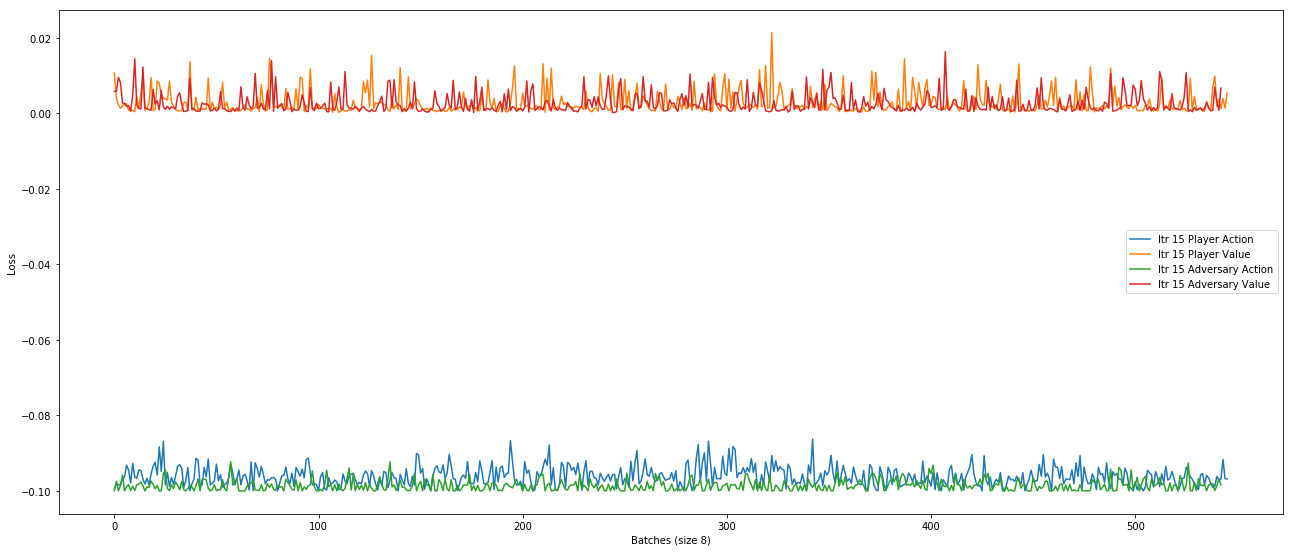

In [68]:
v.plot_nnet_lossesvsbatch(iters=[15])

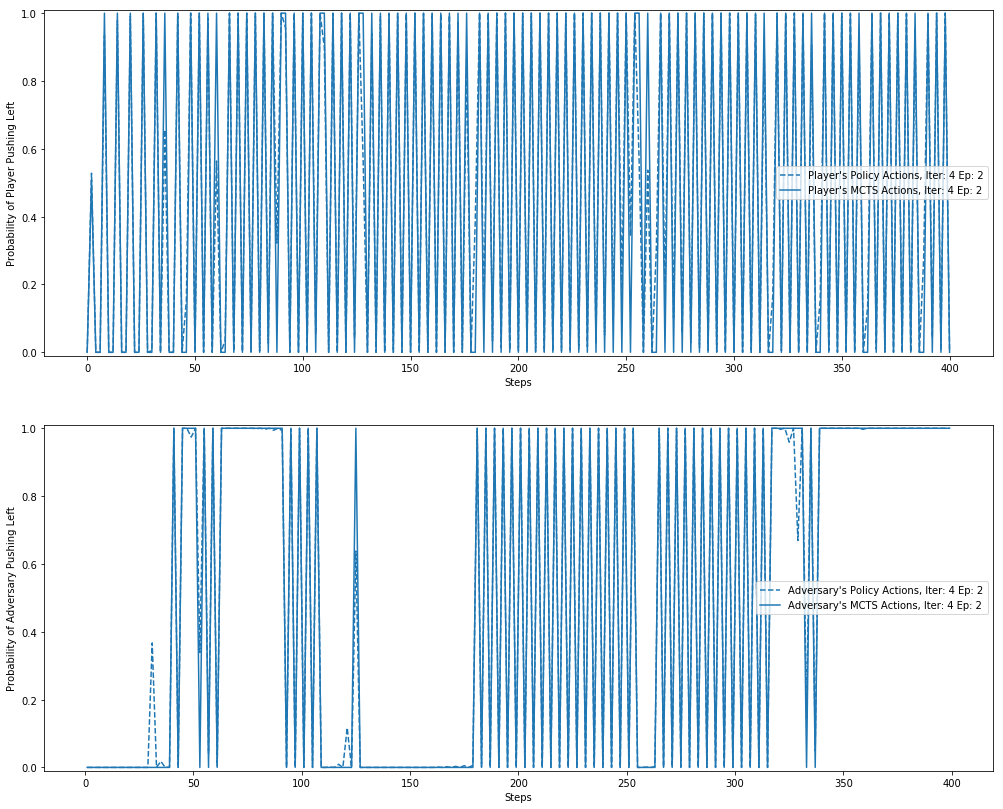

In [57]:
v.plot_actionsvssteps(iters=[4], episode='longest')  # 'longest' if choosing the longest

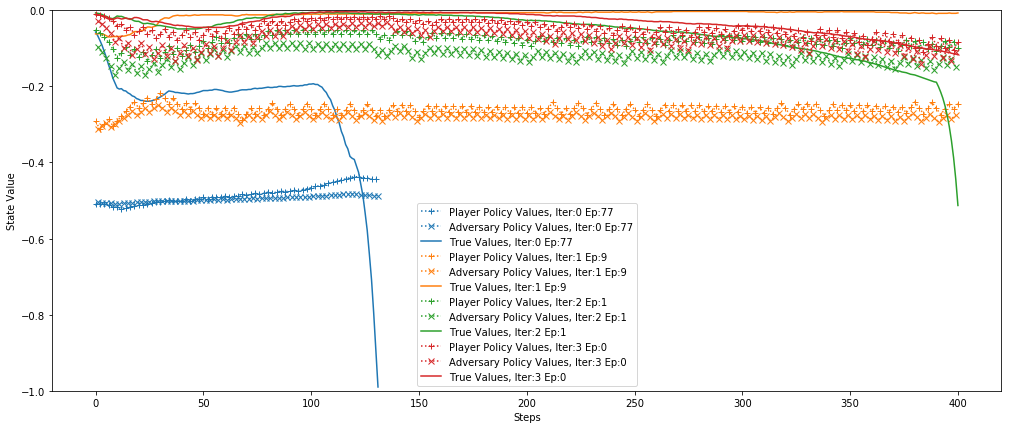

In [34]:
v.plot_valuesvssteps(iters=[0, 1, 2, 3], episode='longest')

ValueError: operands could not be broadcast together with shapes (201,) (257,) (201,) 

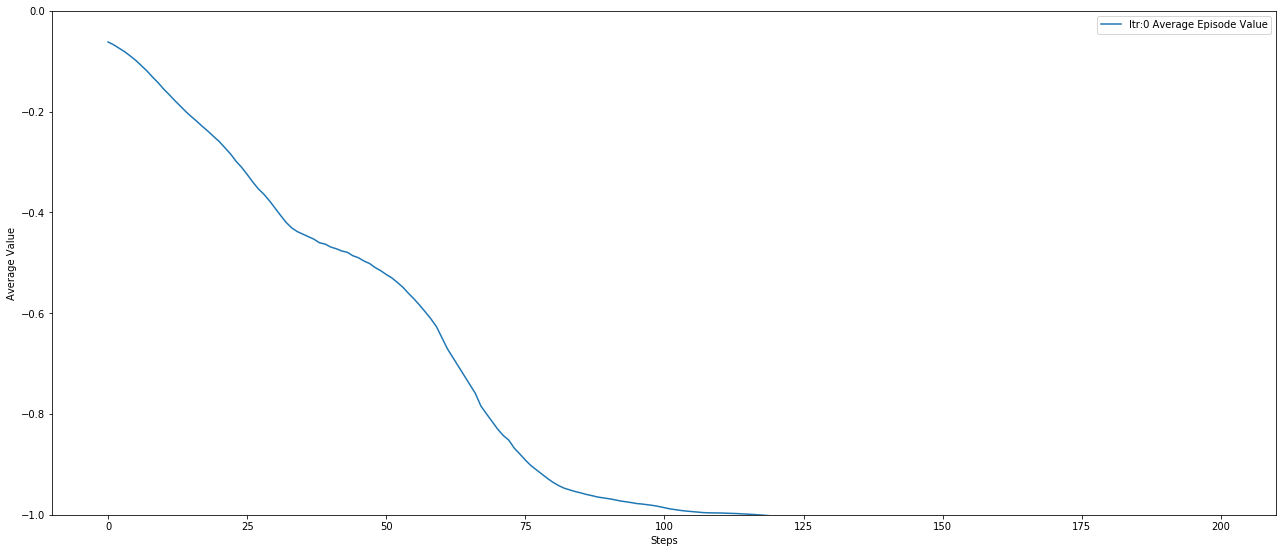

In [27]:
v.plot_episode_statsvsstep(iters=[0, 1, 2, 3, 4, 5, 6, 7], plot_stds=False, plot_all_eps=False)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


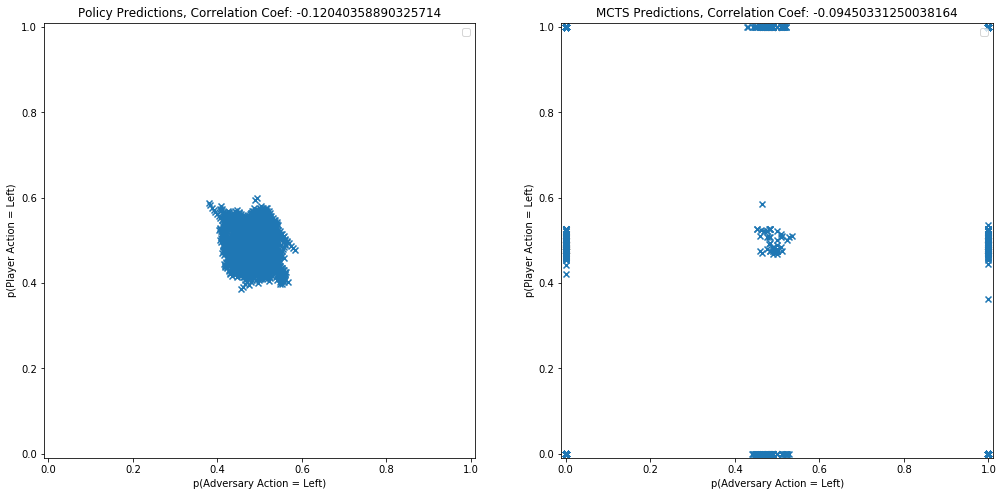

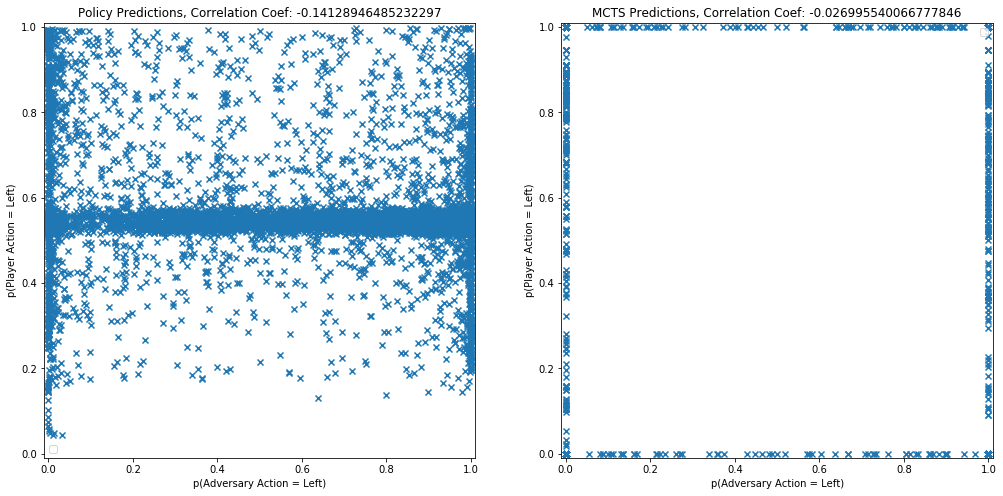

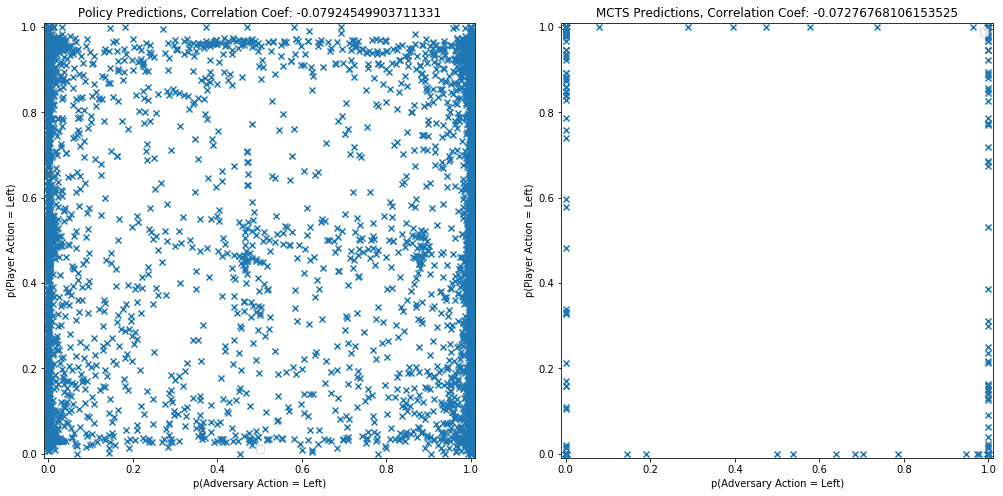

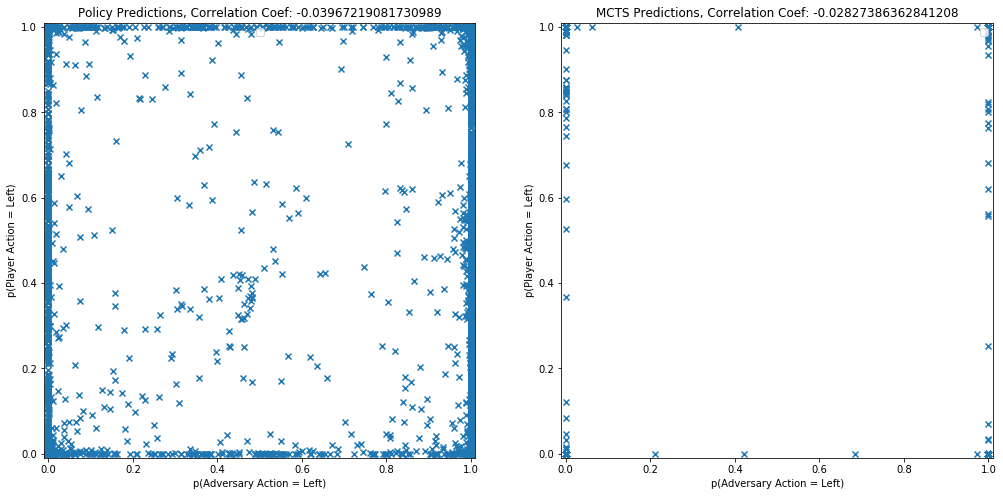

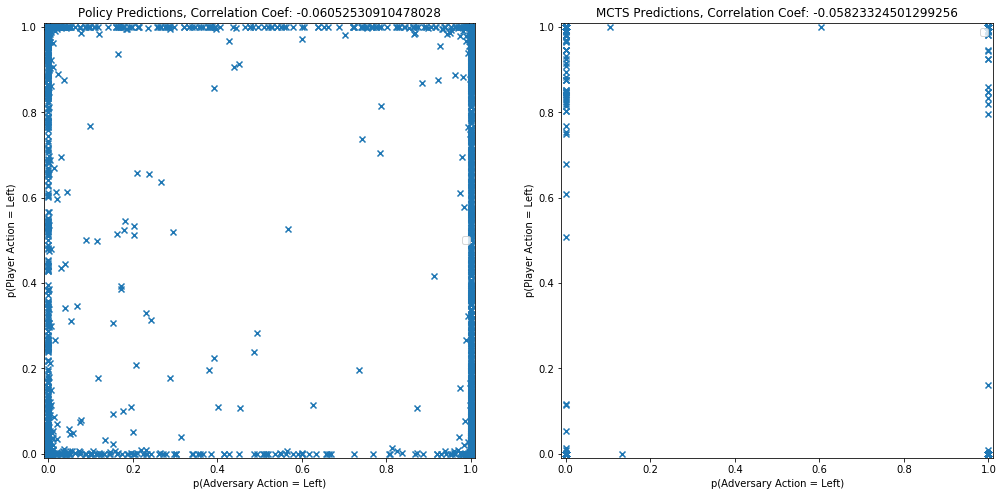

In [42]:
v.plot_playervsadversary(iters=(0, 1, 2, 3, 4))

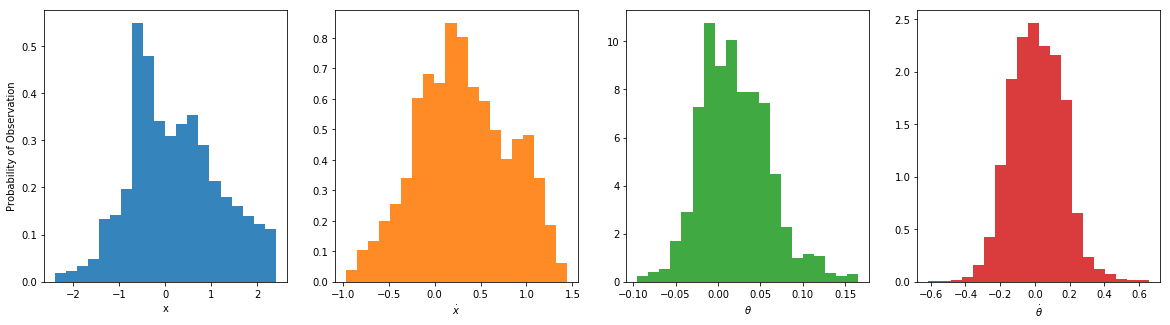

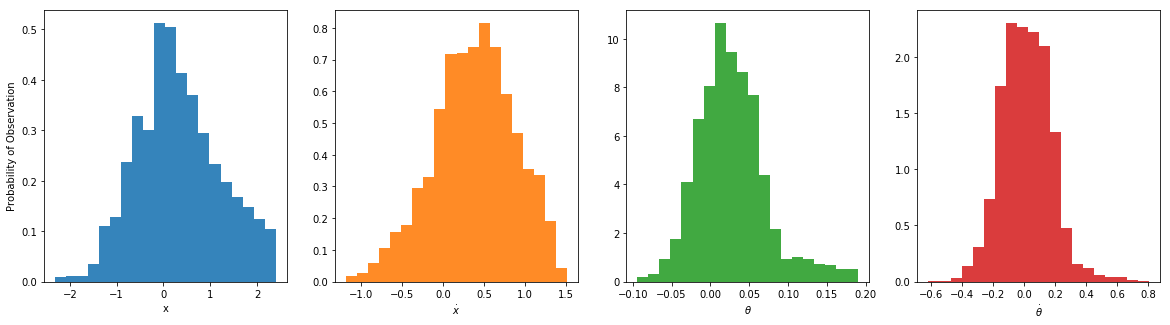

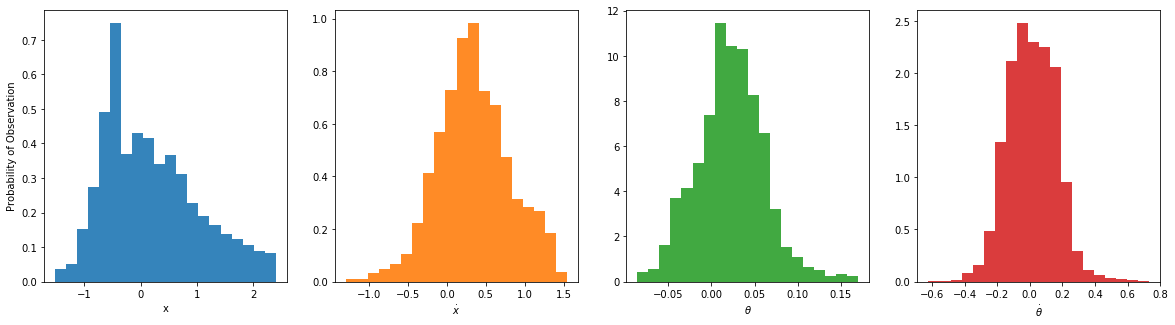

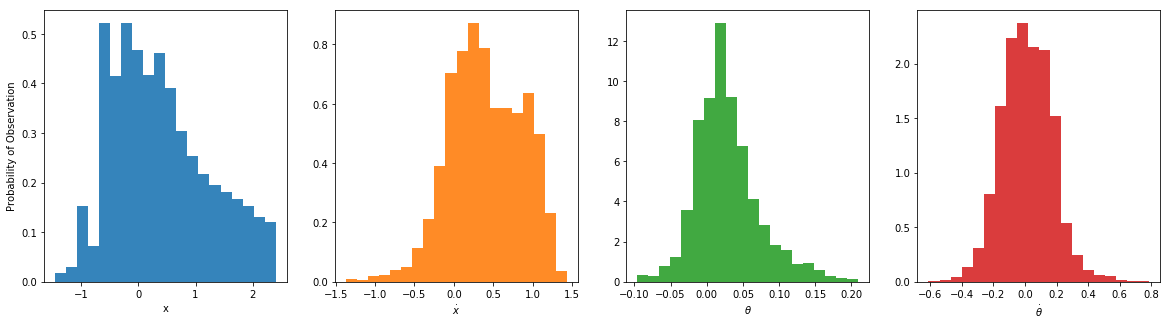

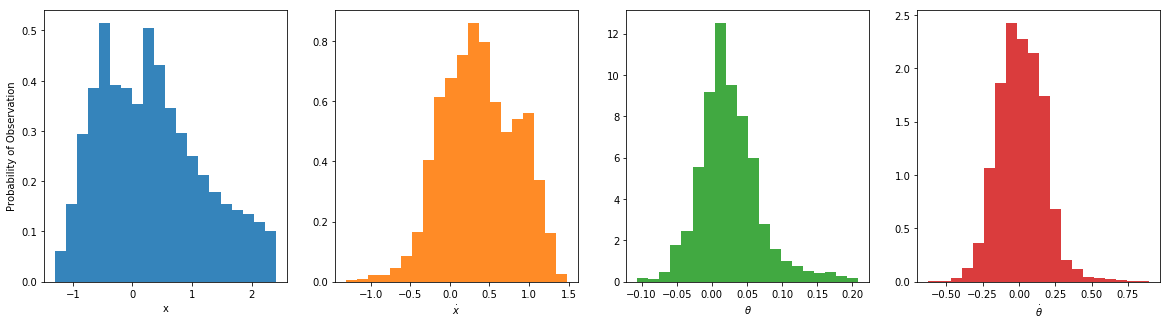

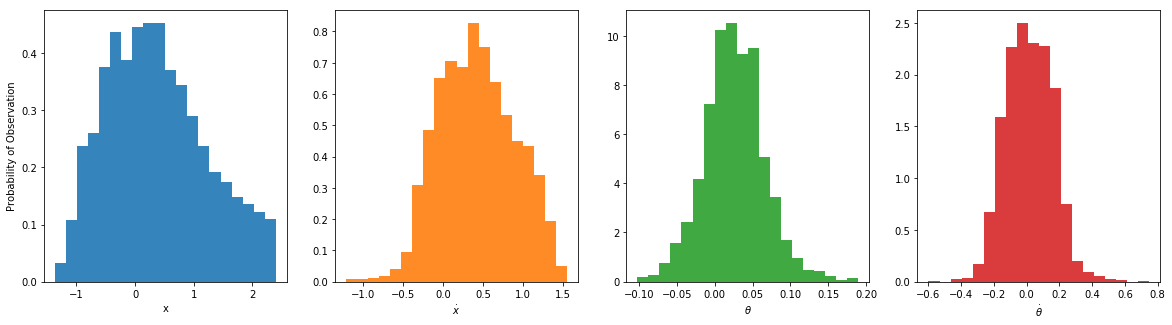

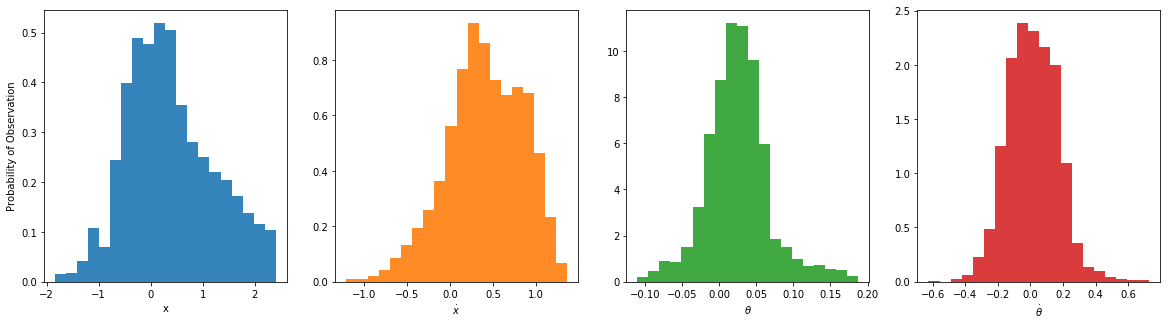

In [45]:
v.plot_observation_histograms(iters=(10, 11, 12, 13, 14, 15, 16), normed=False)

In [ ]:
player_elo = [1083, 838 , 761, 889, 766, 954, 1262, 1254 ,916, 874]